# Admin stuff

Please note: The following script was created for demo purposes only. Some bits are simplified, and some parameters were chosen to make effects easily visible. They may not be optimal for a real data set.
For more EEG/MEG tutorials in MNE-Python, see e.g. https://martinos.org/mne/stable/auto_tutorials/.
Olaf Hauk, MRC Cognition and Brain Sciences Unit, March 2019

# Preparation: Maxfilter

In order to use the freshly acquired MEG data, we first have to pre-process the MEG data using Maxfilter (more later).

 1) Find them:
     ls /megdata/cbu/camtest/meg19*
     
 2) Maxfilter them, save in your data directory:
      maxfilter-2.2.12 -f /megdata/cbu/camtest/meg19_0105/190319/demo_audvis_raw.fif -o ../data/demo_audvis_sss_raw.fif
      
 3) Check that they have arrived safely:
     ls data -l

# (MNE-)Python preparation

In [1]:
# set paths
import sys

# figures within notebook
%matplotlib inline

# import relevant modules

# to keep copy of raw data
from copy import deepcopy

# import numpy package
import numpy as np

# import MNE-Python tools
import mne

# check MNE-Python version
print('MNE-Python version: %s.' % mne.__version__)

MNE-Python version: 0.19.0.


# Reading raw data and events

In [2]:
# Read raw data file ("fiff-format")
raw = mne.io.read_raw_fif('../data/demo_audvis_sss_raw.fif', preload=True)
# check duration of recording

Opening raw data file ../data/demo_audvis_sss_raw.fif...
    Range : 32000 ... 774999 =     32.000 ...   774.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 742999  =      0.000 ...   742.999 secs...


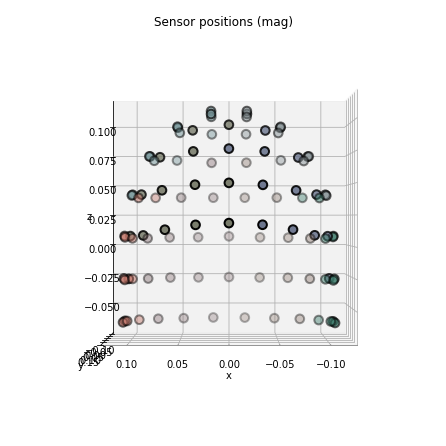

In [3]:
# check sensors (trivial)
fig = raw.plot_sensors(kind='3d', ch_type='mag', ch_groups='position')

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
780 events found
Event IDs: [   1    2 4096 4097 4098]


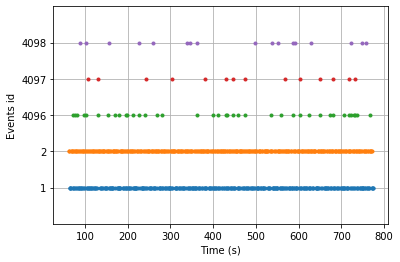

In [4]:
# Find event triggers in raw data file
# triggers are recorded in channel STI101
events = mne.find_events(raw, stim_channel='STI101')
# TO-DO: take into account stimulus delay

# visualise events throughout the recording
fig = mne.viz.plot_events(events, raw.info['sfreq'])

# Filtering raw data

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


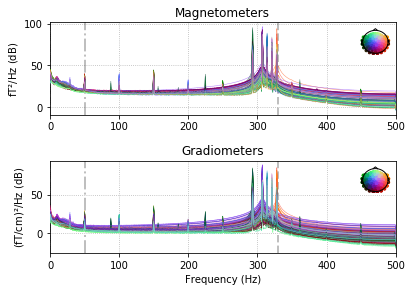

In [5]:
# Plot power spectral density before filtering.
# Note topographic colouring of lines.
# What are the peaks?
fig = raw.plot_psd()

In [ ]:
# Notch filter to remove line noise and harmonics
raw.notch_filter(np.arange(50., 60., 50.), filter_length='auto', phase='zero')

# plot PSD again
fig = raw.plot_psd()

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



In [ ]:
# look at raw data time courses before high/low-pass filtering
fig = raw.plot()

In [9]:
# Apply high-pass filter
raw.filter(l_freq=1., h_freq=None)
# Note: 1Hz is quite a high cut-off frequency, chosen for demo purposes

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



<Raw  |  demo_audvis_sss_raw.fif, n_channels x n_times : 327 x 743000 (743.0 sec), ~1.82 GB, data loaded>

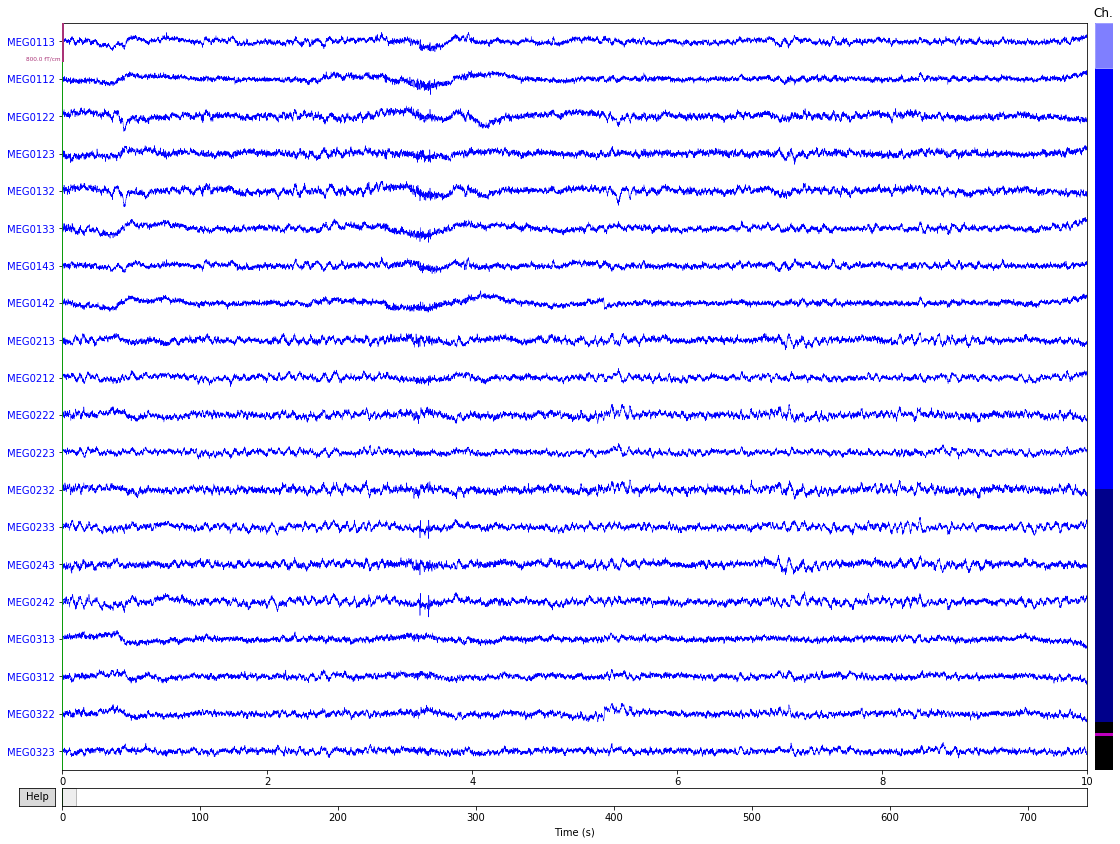

In [10]:
# Plot raw data after high-pass filtering
fig = raw.plot()

In [11]:
# Apply low-pass filter
raw.filter(l_freq=None, h_freq=40.)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



<Raw  |  demo_audvis_sss_raw.fif, n_channels x n_times : 327 x 743000 (743.0 sec), ~1.82 GB, data loaded>

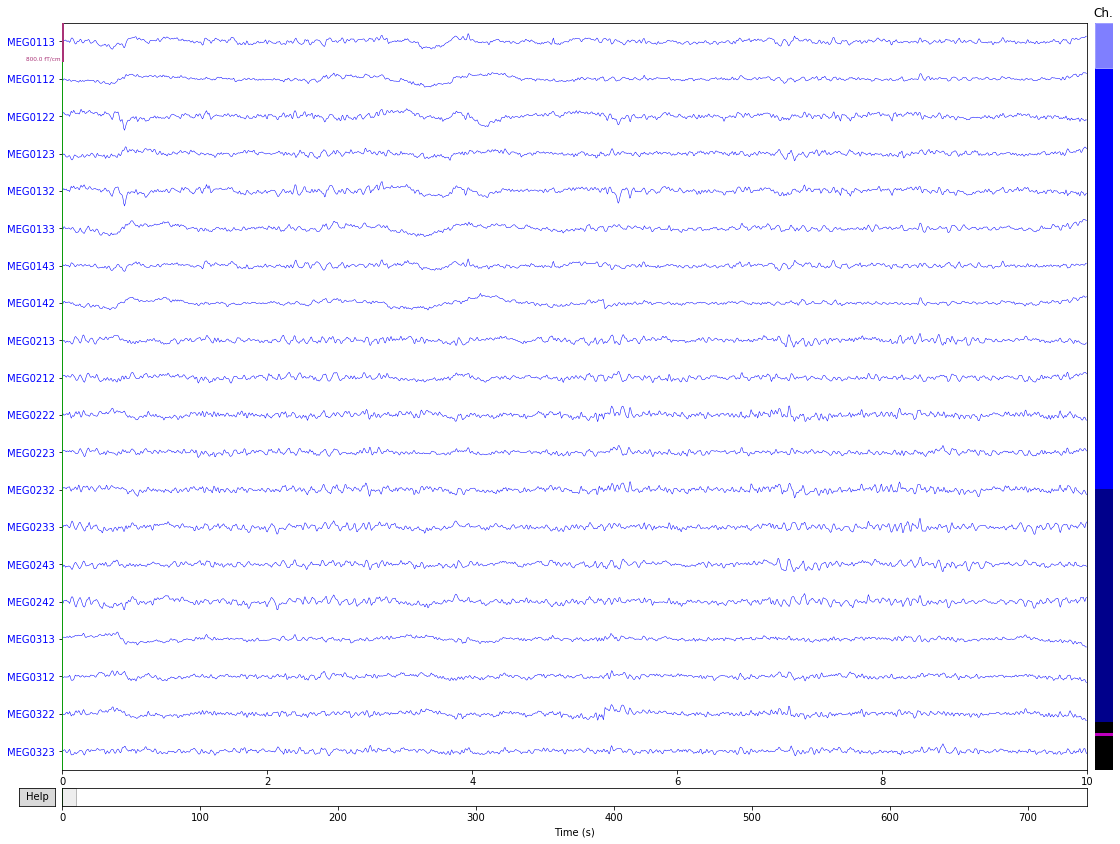

In [12]:
# Plot raw data after low-pass filtering
fig = raw.plot()

In [13]:
raw.save('../data/demo_audvis_sssf_raw.fif', overwrite=True)

Overwriting existing file.
Writing /home/olaf/Methods/IntroNeuroimagingLectures/Workshops_Jan20/data/demo_audvis_sssf_raw.fif
Closing /home/olaf/Methods/IntroNeuroimagingLectures/Workshops_Jan20/data/demo_audvis_sssf_raw.fif [done]


# Eye movement and heart artefacts - ICA

In [6]:
# Re-read and filter raw data
raw = mne.io.read_raw_fif('../data/demo_audvis_sssf_raw.fif', preload=True)

# Apply bandpass filter
# raw.filter(l_freq=1., h_freq=40.)

Opening raw data file ../data/demo_audvis_sssf_raw.fif...
    Range : 32000 ... 774999 =     32.000 ...   774.999 secs
Ready.
Current compensation grade : 0
Reading 0 ... 742999  =      0.000 ...   742.999 secs...


In [7]:
# reduce number of channels for visualisation
# select frontal MEG channels by name
front_chans = mne.read_selection('Right-frontal')[:17]
# hack to remove spaces from channel names
front_chans = [ss.replace(' ', '') for ss in front_chans]
# Add EOG channels
front_chans = ['EOG061', 'EOG062', 'ECG063'] + front_chans

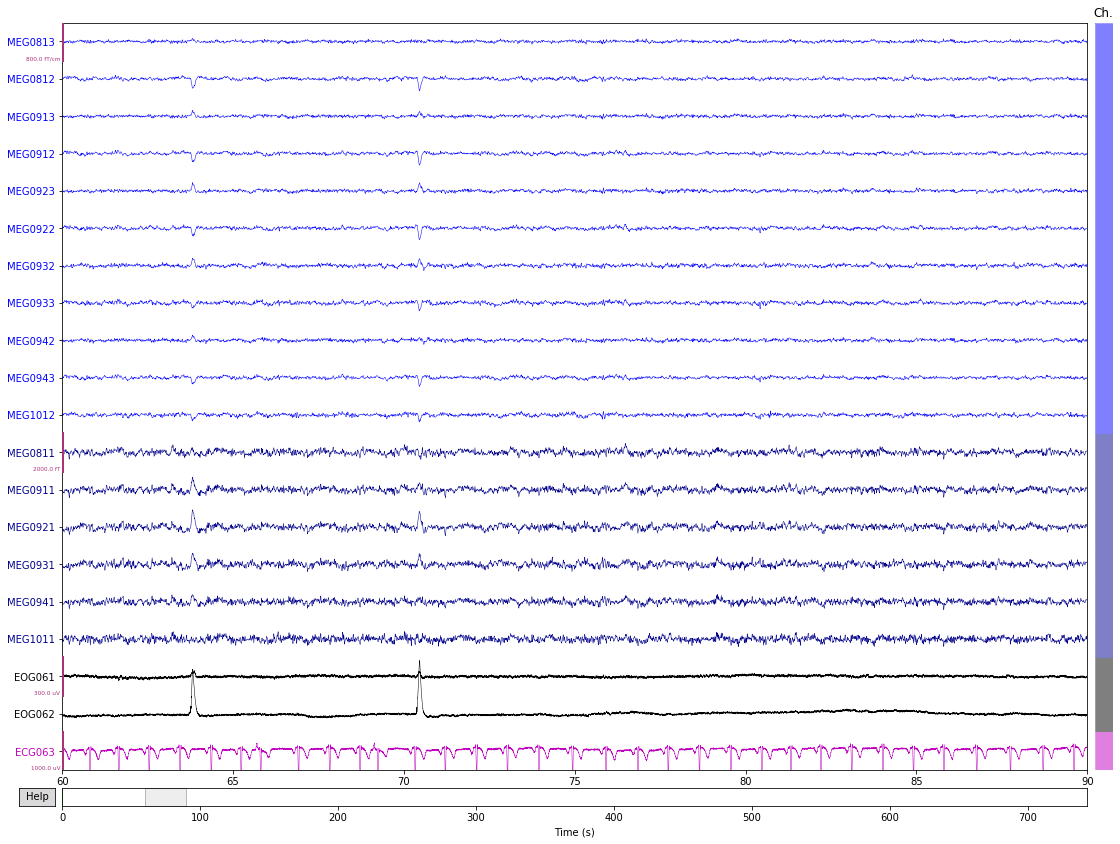

In [12]:
# make copy of raw data for manipulation
rawvis = deepcopy(raw)

# Reduce raw data to frontal channels
rawvis.pick_channels(ch_names=front_chans)

# plot 30 seconds of raw data
fig = rawvis.plot(duration=30., start=60.)
# can you spot some artefacts?

Preparation for ICA (from MNE tutorial)

In [13]:
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs

method = 'fastica'

# Choose other parameters
n_components = 25  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23

# don't consider artefactual data segments
reject = dict(mag=5e-12, grad=4000e-13)

In [14]:
# Define ICA object
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>


In [15]:
# ICA decomposition of raw data
ica.fit(raw, reject=reject)
print(ica)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on MAG : ['MEG0731', 'MEG1521', 'MEG1821', 'MEG1831', 'MEG1911', 'MEG1921', 'MEG1941', 'MEG2111', 'MEG2611']
Artifact detected in [22000, 24000]
Selection by number: 25 components
Fitting ICA took 35.7s.
<ICA  |  raw data decomposition, fit (fastica): 740000 samples, 25 components, channels used: "mag"; "grad">


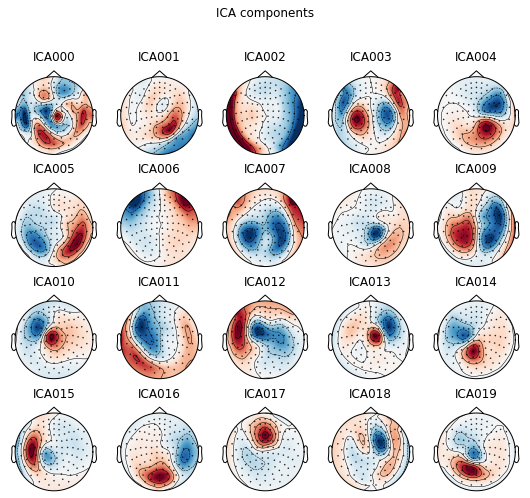

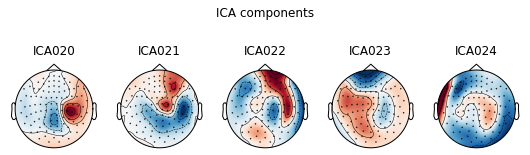

In [16]:
# plot topographies of ICA components
fig = ica.plot_components()
# does anything look suspicious?

EOG channel index for this subject is: [306 307]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 16384 samples (16.384 sec)

Now detecting blinks and generating corresponding events
Found 47 significant peaks
Number of EOG events detected : 47
47 matching events found
No baseline correction applied
Not setting metadata
Loading data for 47 events and 1001 original time points ...
    Rejecting  epoch based on MAG : ['MEG0731', 'MEG1521', 'MEG1821', 'MEG1831', 'MEG1911', 'MEG1921', 'MEG1941', 'MEG2111', '

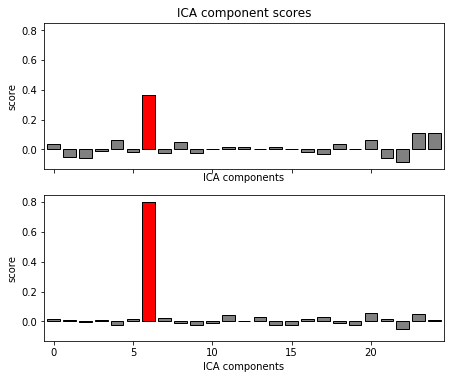

<ipython-input-56-41725967364f>:17: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [6] will be ignored; falling back to ICA.exclude
  fig = ica.plot_sources(eog_average, exclude=eog_inds)


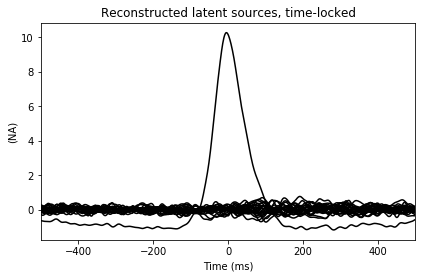

In [56]:
# Find artefactual ICA components - eye blinks

# create epochs around peaks in EOG channel
eog_epochs = create_eog_epochs(raw, reject=reject)

# average across EOG epochs
eog_average = eog_epochs.average()

# correlate ICA component time courses with EOG time courses
eog_inds, scores = ica.find_bads_eog(eog_epochs)

# plot the correlation scores for all ICA components
fig = ica.plot_scores(scores, exclude=eog_inds)
# Is there a winner/loser?

# look at component time course
fig = ica.plot_sources(eog_average, exclude=eog_inds)

Transforming to ICA space (25 components)
Zeroing out 1 ICA components


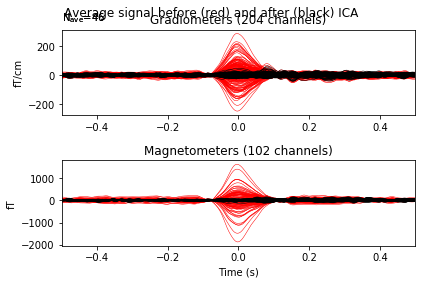

In [57]:
# Plot EOG epochs before (red) and after ICA cleaning
fig = ica.plot_overlay(eog_average, exclude=eog_inds, show=False)

In [58]:
# mark the bad ICA components for removal
ica.exclude = eog_inds

In [59]:
# now we just have to apply ICA to our raw data

# keep a copy of the un-ICAed raw data
rawica = deepcopy(raw)

ica.apply(rawica)
# note "zeroing out" of ICA component

Transforming to ICA space (25 components)
Zeroing out 1 ICA components


<Raw  |  demo_audvis_sssf_raw.fif, n_channels x n_times : 327 x 743000 (743.0 sec), ~1.82 GB, data loaded>

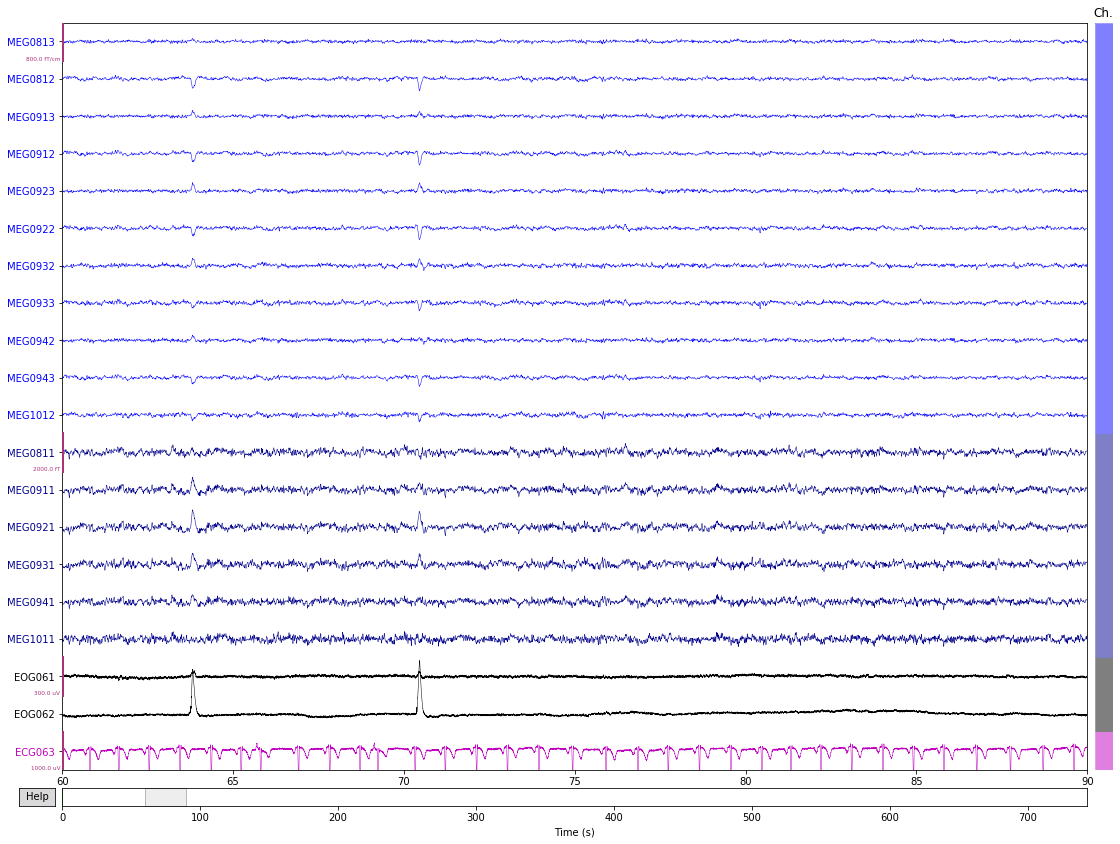

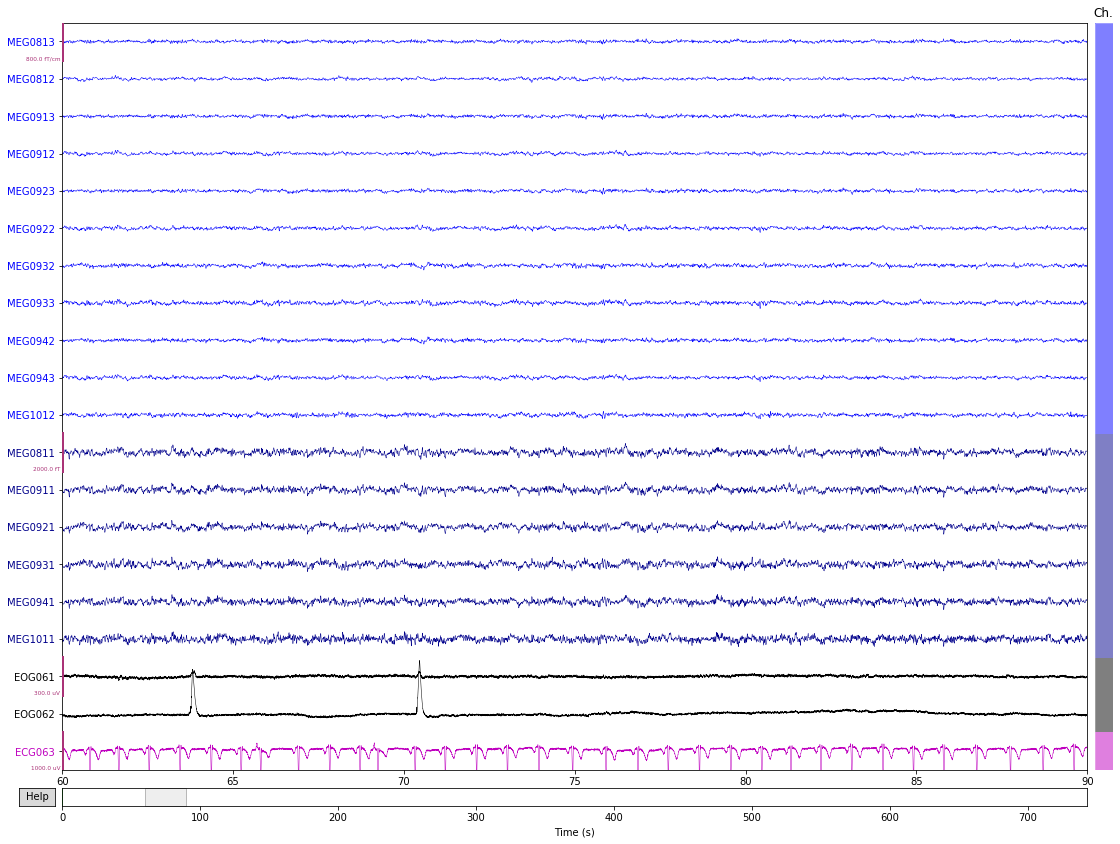

In [60]:
# Plot frontal channels as above, before and after ICA

# BEFORE ICA
# make copy of raw data for manipulation
rawvis = deepcopy(raw)

# Reduce raw data to frontal channels
rawvis.pick_channels(ch_names=front_chans)

# plot 30 seconds of raw data
fig = rawvis.plot(duration=30., start=60.)

# AFTER ICA
# make copy of raw data for manipulation
rawvis = deepcopy(rawica)

# Reduce raw data to frontal channels
rawvis.pick_channels(ch_names=front_chans)

# plot 30 seconds of raw data
fig = rawvis.plot(duration=30., start=60.)

# ICA to remove heart beat artefact

Using channel ECG063 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 16384 samples (16.384 sec)

Number of ECG events detected : 807 (average pulse 65 / min.)
807 matching events found
No baseline correction applied
Not setting metadata
Loading data for 807 events and 1001 original time points ...
    Rejecting  epoch based on MAG : ['MEG0731', 'MEG1521', 'MEG1821', 'MEG1831', 'MEG1911', 'MEG1921', 'MEG1941', 'MEG2111', 'MEG2611']
    Rejecting  epoch based on MAG : ['MEG0731', 'MEG1521', 'MEG1821', 'MEG1831', 'MEG1911', 'MEG1921', 'MEG1941', 'MEG2111', 'ME

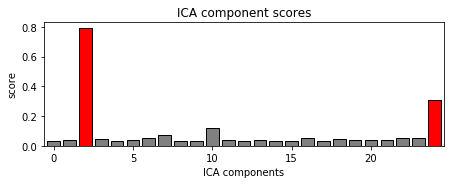

<ipython-input-61-484dce1189ee>:17: DeprecationWarning: The "exclude" parameter is deprecated and will be removed in version 0.20; specify excluded components using the ICA.exclude attribute instead. Provided value of [2, 24] will be ignored; falling back to ICA.exclude
  fig = ica.plot_sources(ecg_average, exclude=ecg_inds)


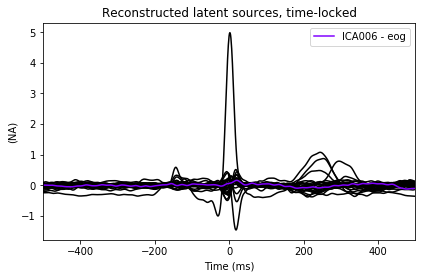

In [61]:
# Find artefactual ICA components - heart beat

# create epochs around peaks in EOG channel
ecg_epochs = create_ecg_epochs(raw, reject=reject)

# average across EOG epochs
ecg_average = ecg_epochs.average()

# correlate ICA component time courses with EOG time courses
ecg_inds, scores = ica.find_bads_ecg(ecg_epochs)

# plot the correlation scores for all ICA components
fig = ica.plot_scores(scores, exclude=ecg_inds)
# Is there a winner/loser?

# look at component time course
fig = ica.plot_sources(ecg_average, exclude=ecg_inds)

In [62]:
# add the bad ICA component for removal
ica.exclude.extend([2])

Transforming to ICA space (25 components)
Zeroing out 2 ICA components


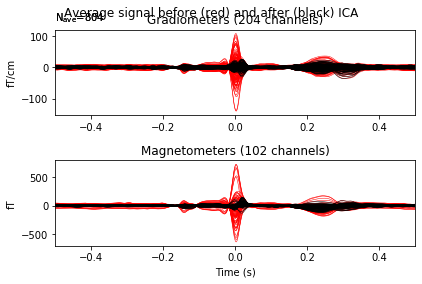

In [63]:
# Plot ECG epochs before (red) and after ICA cleaning
fig = ica.plot_overlay(ecg_average, show=False)

In [64]:
# now we just have to apply ICA to our raw data

# keep a copy of the un-ICAed raw data
rawica = deepcopy(raw)

ica.apply(rawica)
# note "zeroing out" of ICA component

Transforming to ICA space (25 components)
Zeroing out 2 ICA components


<Raw  |  demo_audvis_sssf_raw.fif, n_channels x n_times : 327 x 743000 (743.0 sec), ~1.82 GB, data loaded>

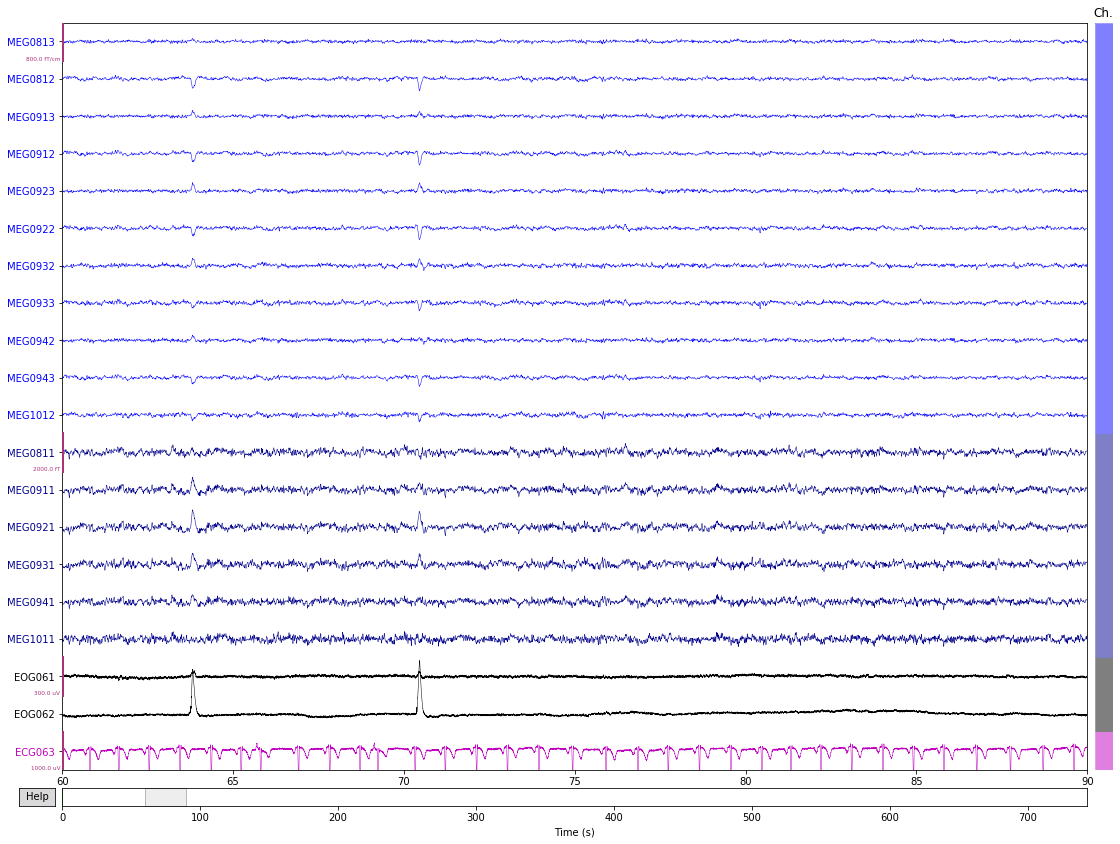

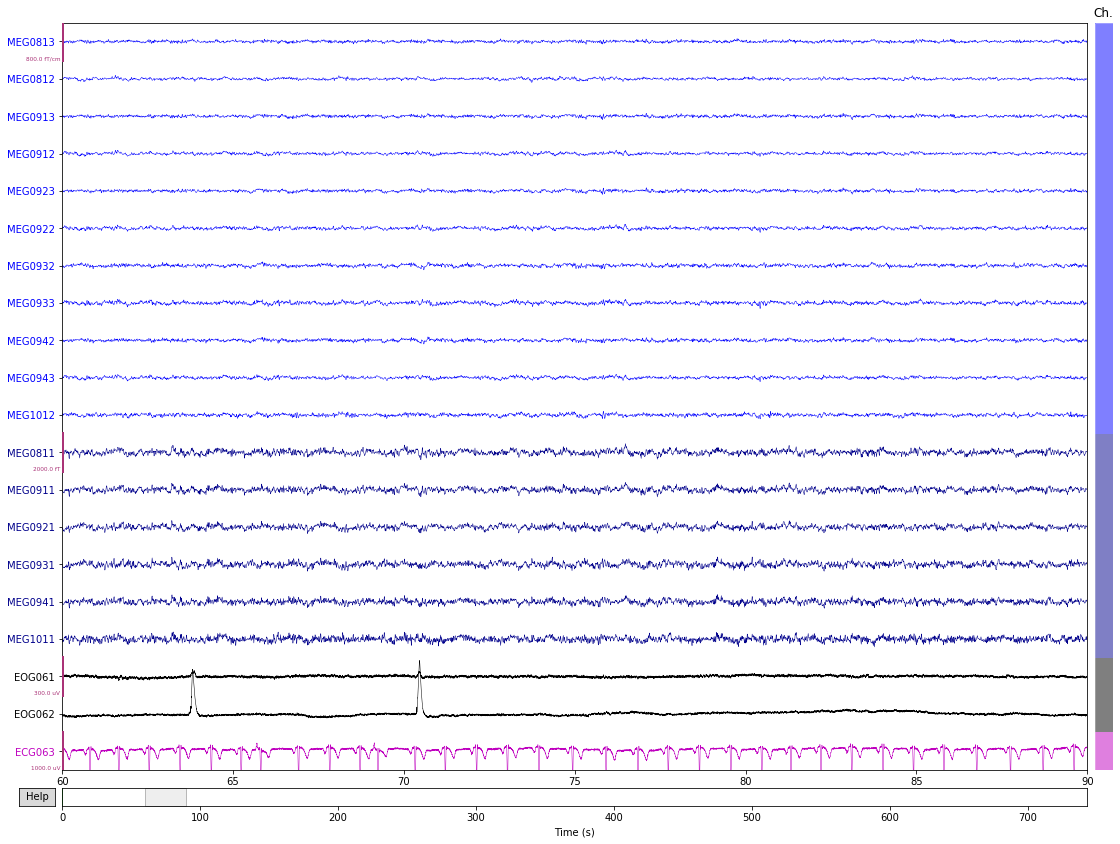

In [65]:
# Plot frontal channels as above, before and after ICA

# BEFORE ICA
# make copy of raw data for manipulation
rawvis = deepcopy(raw)

# Reduce raw data to frontal channels
rawvis.pick_channels(ch_names=front_chans)

# plot 30 seconds of raw data
fig = rawvis.plot(duration=30., start=60.)

# AFTER ICA
# make copy of raw data for manipulation
rawvis = deepcopy(rawica)

# Reduce raw data to frontal channels
rawvis.pick_channels(ch_names=front_chans)

# plot 30 seconds of raw data
fig = rawvis.plot(duration=30., start=60.)

# Epoching and Averaging

In [66]:
# Create epochs around event triggers
epochs = mne.Epochs(rawica, events=events, event_id=[1,2], tmin=-0.2, tmax=0.5, reject=reject)

710 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 710 events and 701 original time points ...
    Rejecting  epoch based on MAG : ['MEG0111', 'MEG0121', 'MEG0131', 'MEG0141', 'MEG0211', 'MEG0221', 'MEG0231', 'MEG0241', 'MEG0311', 'MEG0321', 'MEG0331', 'MEG0341', 'MEG0421', 'MEG0431', 'MEG0441', 'MEG0511', 'MEG0521', 'MEG0531', 'MEG0541', 'MEG0611', 'MEG0631', 'MEG0641', 'MEG0711', 'MEG0731', 'MEG0741', 'MEG0911', 'MEG0921', 'MEG0931', 'MEG0941', 'MEG1021', 'MEG1031', 'MEG1041', 'MEG1111', 'MEG1121', 'MEG1131', 'MEG1141', 'MEG1211', 'MEG1231', 'MEG1241', 'MEG1311', 'MEG1321', 'MEG1331', 'MEG1341', 'MEG1431', 'MEG1441', 'MEG1511', 'MEG1521', 'MEG1531', 'MEG1541', 'MEG1631', 'MEG1641', 'MEG1711', 'MEG1721', 'MEG1731', 'MEG1741', 'MEG1811', 'MEG1821', 'MEG1831', 'MEG1911', 'MEG1921', 'MEG1931', 'MEG1941', 'MEG2011', 'MEG2021', 'MEG2031', 'MEG2041', 'MEG2111', 'MEG2121', 'MEG2131', 'MEG2141', 'MEG2211', 'MEG2221', 'MEG2241', 'MEG2311', 'MEG2321', 'MEG2331', 'MEG2341', 'MEG2411', 'MEG2421', 'MEG2431', 'MEG2441', 'MEG2511', 

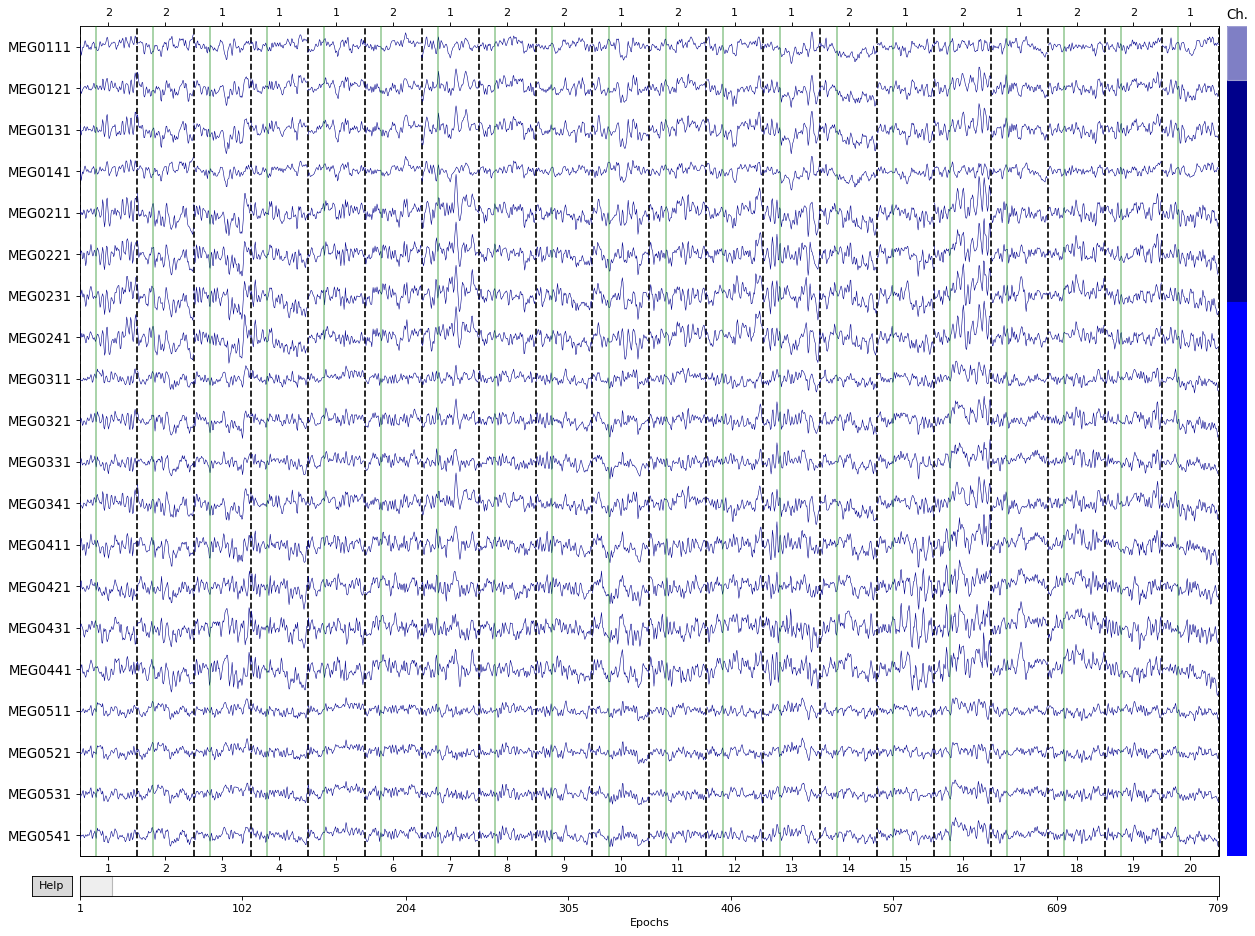

In [67]:
# Quick look at epochs
fig = epochs.plot(block=True)

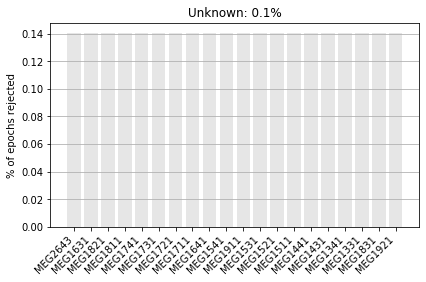

In [68]:
# plot the log info for epoch rejection
fig = epochs.plot_drop_log()
# Why are there no rejections due to eye blinks?

In [69]:
# Average epochs for event types separately
evokeds = [] # initialise list for evoked objects
# Add averages for two conditions to list
evokeds.append(epochs['1'].average())
evokeds.append(epochs['2'].average())

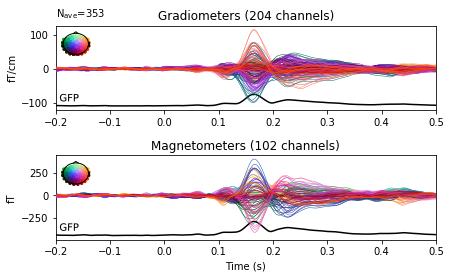

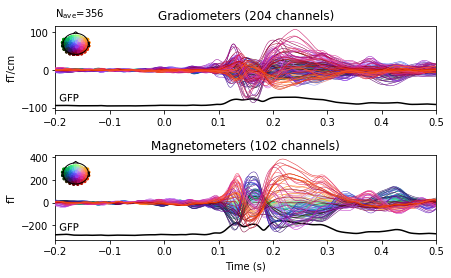

In [70]:
# plot average time courses for event types separately
# line colors reflect sensor position
# Global Field Power (GFP) included at bottom
fig = evokeds[0].plot(spatial_colors=True, gfp=True)
fig = evokeds[1].plot(spatial_colors=True, gfp=True)
# Which one is visual, which one is auditory?

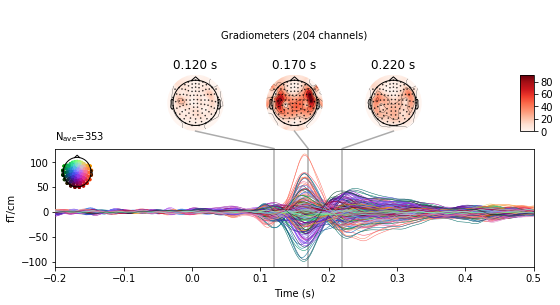

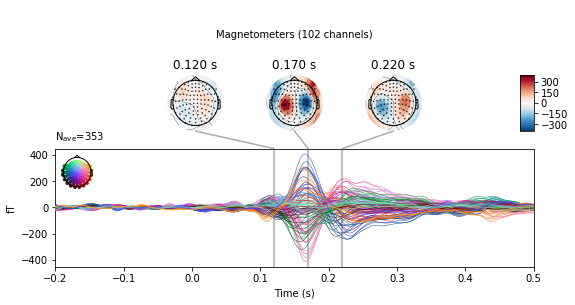

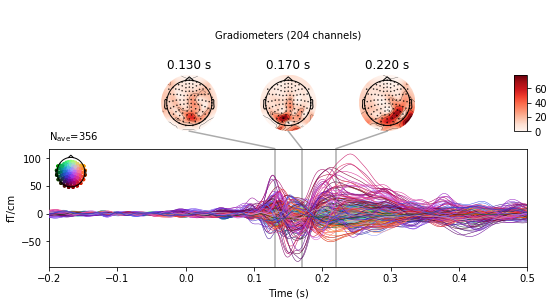

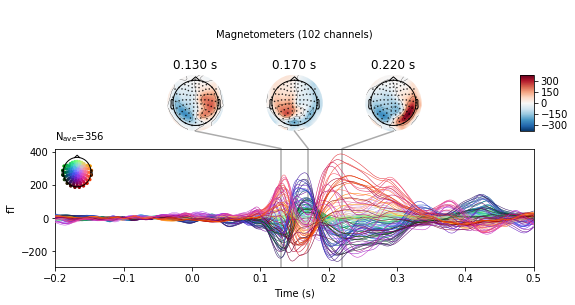

In [71]:
# Let's look at topographies
fig = evokeds[0].plot_joint([0.12,0.17,0.22])

fig = evokeds[1].plot_joint([0.13,0.17,0.22])

In [72]:
# If we are happy, we can save the evoked data.
mne.write_evokeds('../data/demo_audvis-ave.fif', evokeds)

# Compute Noise Covariance

In [73]:
noise_cov = mne.compute_covariance(epochs, tmin=-0.2, tmax=0., method=['empirical'])

Loading data for 353 events and 701 original time points ...
Loading data for 356 events and 701 original time points ...
Computing data rank from raw with rank=None
    Using tolerance 1.8e-08 (2.2e-16 eps * 306 dim * 2.7e+05  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 0 projectors


<ipython-input-73-64dbb6f4a88e>:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  noise_cov = mne.compute_covariance(epochs, tmin=-0.2, tmax=0., method=['empirical'])


    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 304
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 142509
[done]


Computing data rank from covariance with rank=None
    Using tolerance 1.1e-14 (2.2e-16 eps * 102 dim * 0.48  max singular value)
    Estimated rank (mag): 102
    MAG: rank 102 computed from 102 data channels with 0 projectors
Computing data rank from covariance with rank=None
    Using tolerance 1e-13 (2.2e-16 eps * 204 dim * 2.2  max singular value)
    Estimated rank (grad): 204
    GRAD: rank 204 computed from 204 data channels with 0 projectors


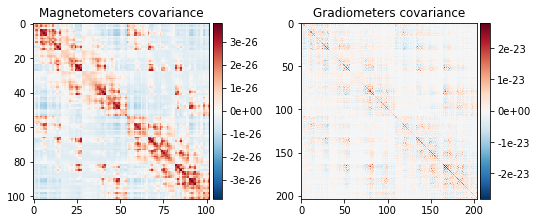

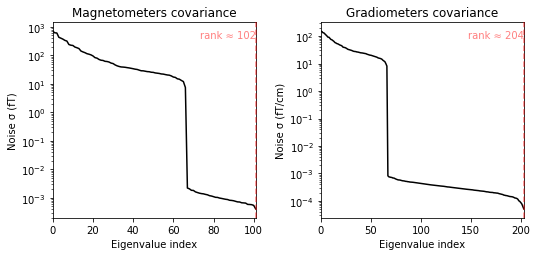

In [78]:
# Plot noise covariance matrix
fig = noise_cov.plot(epochs.info)

# Note: the rank estimation may be misleading after Maxfilter

In [79]:
# save noise covariance matrix
noise_cov.save('../data/demo_audvis-cov.fif')

## Visualisation of MEG and EEG

In [80]:
# read evoked data from MNE sample data set
# data are not yet baseline-corrected
evokeds2 = mne.read_evokeds('../data/MEG_sample/sample/sample_audvis-ave.fif', baseline=(-0.2,0.))

Reading ../data/MEG_sample/sample/sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Right Auditory)
        0 CTF compensation matrices available
        nave = 61 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
   

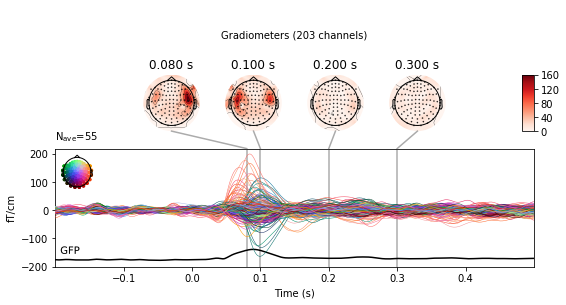

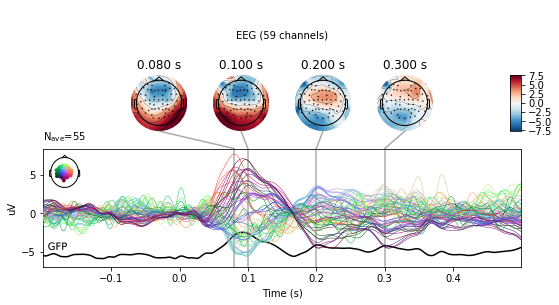

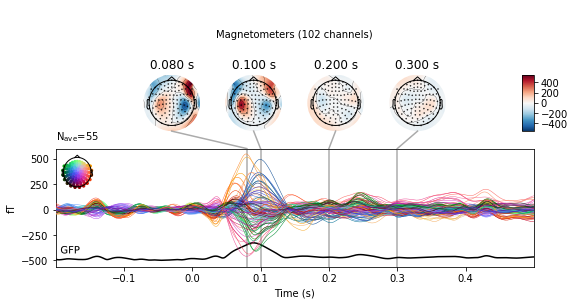

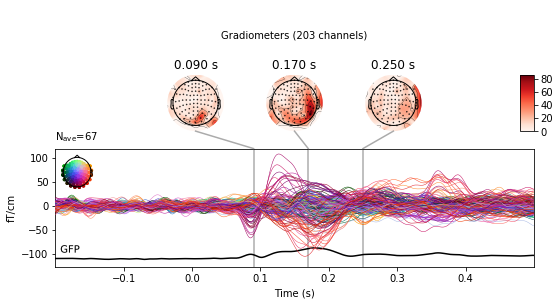

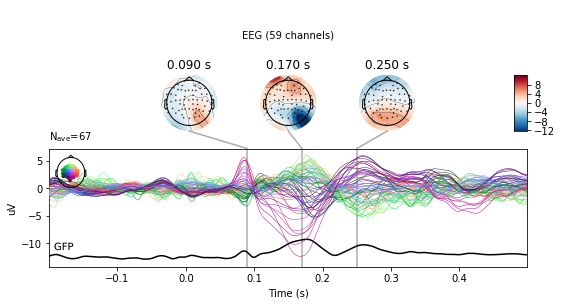

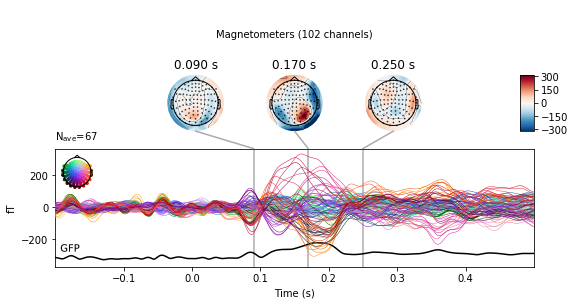

In [81]:
# data set contains four conditions
# plot two of them
fig = evokeds2[0].plot_joint([0.08, 0.1,0.2,0.3], ts_args={'gfp': True})
fig = evokeds2[2].plot_joint([0.09,0.17,0.25], ts_args={'gfp': True})